In [311]:
import pandas as pd
import numpy as np
import missingno
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from time import process_time
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [312]:
bucket = 'andrew-data-sagemaker/WeatherClassifier'
data_key = 'weatherAUS.csv' 
data_location = 's3://{}/{}'.format(bucket, data_key) 
weather_df = pd.read_csv(data_location)
weather_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [313]:
print(weather_df.shape)

(142193, 24)


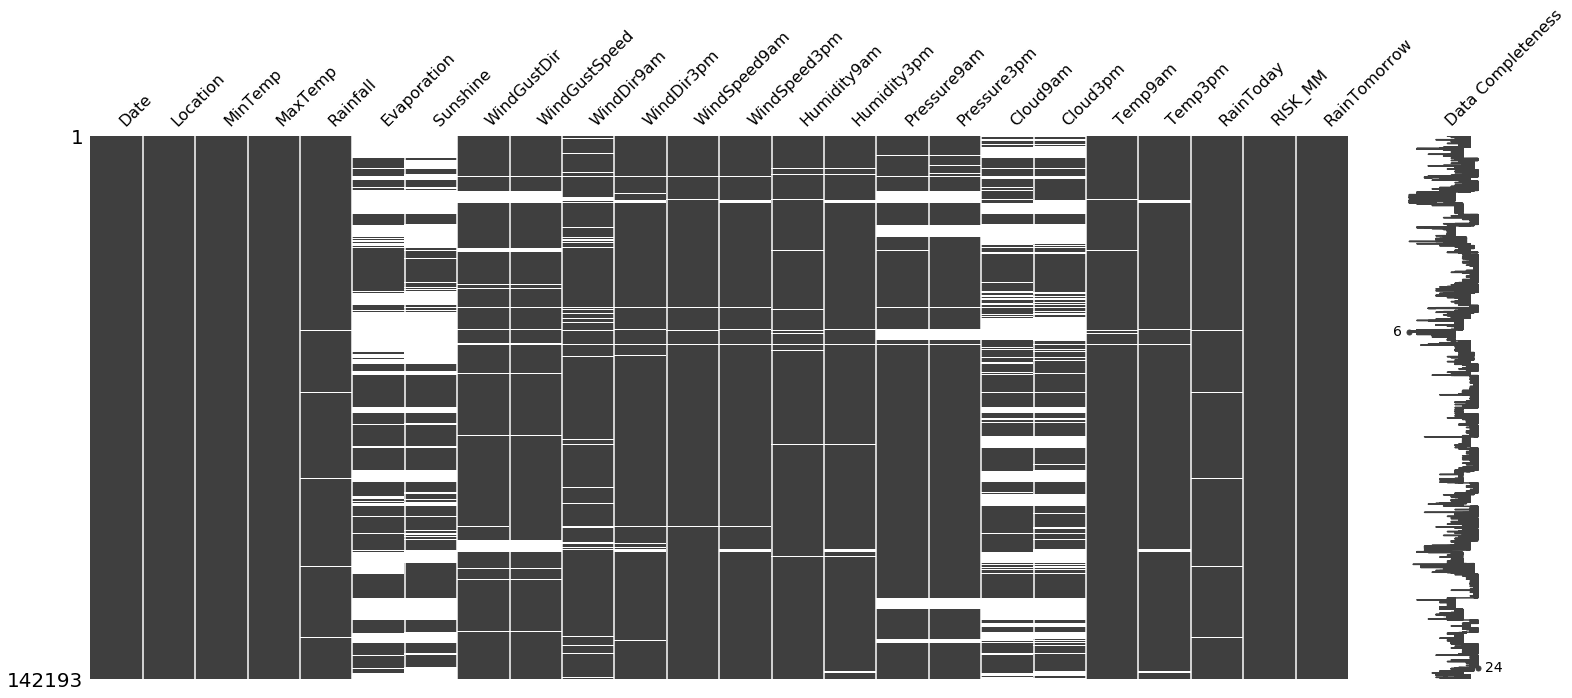

In [345]:
missingno.matrix(weather_df, labels=True)

There are 49 locations


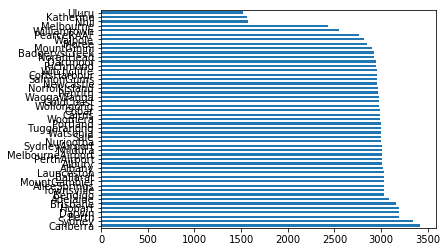

In [315]:
weather_df.Location.value_counts().plot(kind='barh')
print('There are {} locations'.format(len(weather_df.Location.value_counts())))

In [316]:
print(weather_df.MinTemp.describe())
print('There are {} missing values'.format(weather_df.MinTemp.isnull().sum()))

count    141556.000000
mean         12.186400
std           6.403283
min          -8.500000
25%           7.600000
50%          12.000000
75%          16.800000
max          33.900000
Name: MinTemp, dtype: float64
There are 637 missing values


In [317]:
#weather_df['MinTemp'].fillna(weather_df['MinTemp'].mean(), inplace=True)
#print('There are {} missing values'.format(weather_df.MinTemp.isna().sum()))

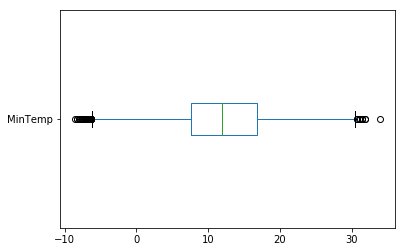

In [318]:
weather_df.MinTemp.plot(kind='box', vert=False)

In [319]:
print(weather_df.MaxTemp.describe())
print('There are {} missing values'.format(weather_df.MaxTemp.isnull().sum()))

count    141871.000000
mean         23.226784
std           7.117618
min          -4.800000
25%          17.900000
50%          22.600000
75%          28.200000
max          48.100000
Name: MaxTemp, dtype: float64
There are 322 missing values


In [320]:
#weather_df['MaxTemp'].fillna(weather_df['MaxTemp'].mean(), inplace=True)
#print('There are {} missing values'.format(weather_df.MaxTemp.isna().sum()))

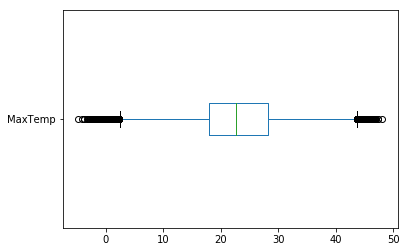

In [321]:
weather_df.MaxTemp.plot(kind='box', vert=False)

There could be an issue with filling the temp with just the mean. Possibilities of a min temp of 25 and the max temp will be 23. That will make no sense. Best to use a prediction model perhaps?

In [322]:
weather_df[weather_df.MaxTemp < weather_df.MinTemp]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow


Convert nan matches to 1000
Then fill na
Then drop the 1000
then fill with the means

In [323]:
weather_df.loc[weather_df.MinTemp.isnull() & weather_df.MaxTemp.isnull(), ['MinTemp','MaxTemp']] = 1000
print('Missing Max Temp: {}, Missing Min Temp: {}'.format(weather_df.MaxTemp.isnull().sum(), weather_df.MinTemp.isnull().sum()))

Missing Max Temp: 234, Missing Min Temp: 549


In [324]:
Temp_df = pd.concat([weather_df.MinTemp, weather_df.MaxTemp], axis=1)
Temp_df = Temp_df.dropna()
X,y = Temp_df.iloc[:,Temp_df.columns != 'MaxTemp'], Temp_df['MaxTemp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [325]:
Temp_null = weather_df[weather_df.MaxTemp.isnull()]
Max_null = pd.concat([Temp_null.MinTemp, Temp_null.MaxTemp], axis=1)
Max_null = Max_null.drop(columns=['MaxTemp'])
Max_null = Max_null.dropna()
Temp_min_null = weather_df[weather_df.MinTemp.isnull()]
Min_null = pd.concat([Temp_min_null.MinTemp, Temp_min_null.MaxTemp], axis=1)
Min_null = Min_null.drop(columns=['MinTemp'])
Min_null = Min_null.dropna()

In [326]:
Neighbors_list = list(range(1,50))
Neighbors = list(filter(lambda x: x %2 != 0, Neighbors_list))
score = []
for k in Neighbors:
    start_time = process_time()
    max_model = KNeighborsRegressor(n_neighbors=k)
    max_model.fit(X_train, y_train)
    max_predictions = max_model.predict(X_test)
    mse = mean_squared_error(max_predictions, y_test)
    rmse = sqrt(mse)
    end_time = process_time()
    time_lapsed = end_time - start_time
    score.append(rmse)
    print('KNN on neighbors = {} has a rmse of {} and took {} seconds to compute'.format(k, rmse, time_lapsed))

KNN on neighbors = 1 has a rmse of 7.030469061637774 and took 0.2590077190000102 seconds to compute
KNN on neighbors = 3 has a rmse of 5.54425235511653 and took 0.2635581800000182 seconds to compute
KNN on neighbors = 5 has a rmse of 5.246217388602983 and took 0.2661143020000054 seconds to compute
KNN on neighbors = 7 has a rmse of 5.123454091999229 and took 0.2706280580000566 seconds to compute
KNN on neighbors = 9 has a rmse of 5.0637460522362865 and took 0.27014576900000975 seconds to compute
KNN on neighbors = 11 has a rmse of 5.011745327284819 and took 0.2772837120000986 seconds to compute
KNN on neighbors = 13 has a rmse of 4.987400541140674 and took 0.27744720500004405 seconds to compute
KNN on neighbors = 15 has a rmse of 4.951597775995567 and took 0.2842146610000782 seconds to compute
KNN on neighbors = 17 has a rmse of 4.928282435455426 and took 0.28782164800009014 seconds to compute
KNN on neighbors = 19 has a rmse of 4.927096487049278 and took 0.29964342800008126 seconds to

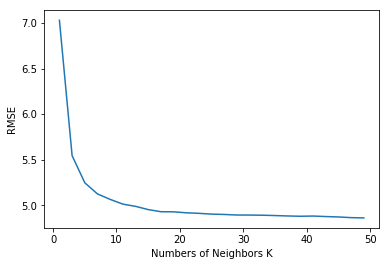

In [327]:
plt.plot(Neighbors, score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [328]:
cv_scores = []
kf = KFold(10, True)
fold = 0
for k in Neighbors:
    cv_max_model = KNeighborsRegressor(n_neighbors=k)
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_max_model.fit(X_train, y_train)
        predictions = cv_max_model.predict(X_test)
        mse = mean_squared_error(predictions, y_test)
        rmse = sqrt(mse)
        temp_cv_scores.append(rmse)
    cv_scores.append(np.min(temp_cv_scores)) 

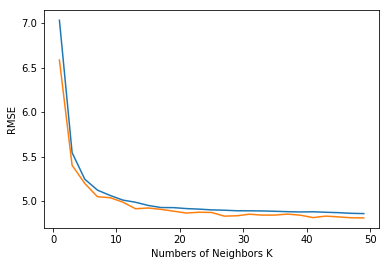

In [329]:
plt.plot(Neighbors, score, Neighbors, cv_scores)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [330]:
max_model = KNeighborsRegressor(n_neighbors=20)
max_model.fit(X_train, y_train)
max_predictions = max_model.predict(Max_null)
max_results = pd.DataFrame(max_predictions, columns=['MaxTemp'])
max_results = max_results.round(1)
weather_df['MaxTemp'] = weather_df['MaxTemp'].fillna(max_results['MaxTemp'].values[0])

In [331]:
weather_df.MaxTemp.describe()

count    142193.000000
mean         23.836344
std          25.311181
min          -4.800000
25%          17.900000
50%          22.700000
75%          28.200000
max        1000.000000
Name: MaxTemp, dtype: float64

In [332]:
Temp_df = pd.concat([weather_df.MinTemp, weather_df.MaxTemp], axis=1)
Temp_df = Temp_df.dropna()
X,y = Temp_df.iloc[:,Temp_df.columns != 'MinTemp'], Temp_df['MinTemp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [333]:
Neighbors_list = list(range(1,50))
Neighbors = list(filter(lambda x: x %2 != 0, Neighbors_list))
min_score = []
for k in Neighbors:
    start_time = process_time()
    min_model = KNeighborsRegressor(n_neighbors=k)
    min_model.fit(X_train, y_train)
    min_predictions = min_model.predict(X_test)
    mse = mean_squared_error(min_predictions, y_test)
    rmse = sqrt(mse)
    end_time = process_time()
    time_lapsed = end_time - start_time
    min_score.append(rmse)
    print('KNN on neighbors = {} has a rmse of {} and took {} seconds to compute'.format(k, rmse, time_lapsed))

KNN on neighbors = 1 has a rmse of 5.994925755074296 and took 0.24550183499991363 seconds to compute
KNN on neighbors = 3 has a rmse of 4.865523613875711 and took 0.24867968800003837 seconds to compute
KNN on neighbors = 5 has a rmse of 4.68364637267548 and took 0.24957861099983347 seconds to compute
KNN on neighbors = 7 has a rmse of 4.549044162028489 and took 0.25617825700010144 seconds to compute
KNN on neighbors = 9 has a rmse of 4.518671913692557 and took 0.2541721840000264 seconds to compute
KNN on neighbors = 11 has a rmse of 4.477377946857635 and took 0.2560309339999094 seconds to compute
KNN on neighbors = 13 has a rmse of 4.448303432092907 and took 0.26339661700012584 seconds to compute
KNN on neighbors = 15 has a rmse of 4.428236581830936 and took 0.26980026699993687 seconds to compute
KNN on neighbors = 17 has a rmse of 4.416540257801104 and took 0.28043015100001867 seconds to compute
KNN on neighbors = 19 has a rmse of 4.397975100800634 and took 0.2879927359999783 seconds 

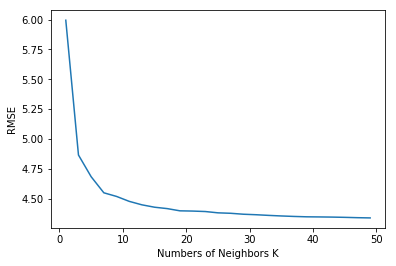

In [334]:
plt.plot(Neighbors, min_score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [335]:
min_cv_scores = []
kf = KFold(10, True)
fold = 0
for k in Neighbors:
    min_cv_model = KNeighborsRegressor(n_neighbors=k)
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        min_cv_model.fit(X_train, y_train)
        predictions = min_cv_model.predict(X_test)
        mse = mean_squared_error(predictions, y_test)
        rmse = sqrt(mse)
        temp_cv_scores.append(rmse)
    min_cv_scores.append(np.min(temp_cv_scores)) 

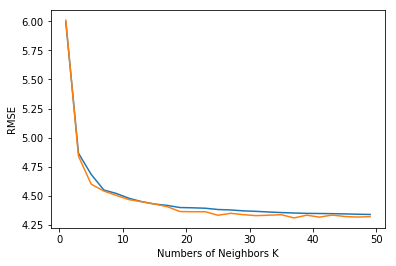

In [336]:
plt.plot(Neighbors, min_score, Neighbors, min_cv_scores)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [337]:
optimal_k = Neighbors[min_cv_scores.index(min(min_cv_scores))]
print(optimal_k)

37


In [338]:
min_model = KNeighborsRegressor(n_neighbors=41)
min_model.fit(X_train, y_train)
min_predictions = min_model.predict(Min_null)
min_results = pd.DataFrame(min_predictions, columns=['MinTemp'])
min_results = min_results.round(1)
weather_df['MinTemp'] = weather_df['MinTemp'].fillna(min_results['MinTemp'].values[0])

In [339]:
weather_df.MinTemp.describe()

count    142193.000000
mean         12.783888
std          25.385046
min          -8.500000
25%           7.600000
50%          12.000000
75%          16.800000
max        1000.000000
Name: MinTemp, dtype: float64

In [340]:
weather_df.loc[weather_df['MinTemp'] == 1000, ['MinTemp']] = np.nan
weather_df.loc[weather_df['MaxTemp'] == 1000, ['MaxTemp']] = np.nan

In [343]:
print(weather_df.MaxTemp.isnull().sum())
print(weather_df.MinTemp.isnull().sum())

0
0


In [344]:
weather_df['MinTemp'].fillna(weather_df['MinTemp'].mean(), inplace=True)
weather_df['MaxTemp'].fillna(weather_df['MaxTemp'].mean(), inplace=True)
print(weather_df.MinTemp.describe())
print(weather_df.MaxTemp.describe())

count    142193.000000
mean         12.172544
std           6.392794
min          -8.500000
25%           7.600000
50%          12.000000
75%          16.800000
max          33.900000
Name: MinTemp, dtype: float64
count    142193.000000
mean         23.231845
std           7.110646
min          -4.800000
25%          17.900000
50%          22.700000
75%          28.200000
max          48.100000
Name: MaxTemp, dtype: float64


In [55]:
print(weather_df.Rainfall.describe())
print('There are {} missing values'.format(weather_df.Rainfall.isnull().sum()))

count    140787.000000
mean          2.349974
std           8.465173
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max         371.000000
Name: Rainfall, dtype: float64
There are 1406 missing values


In [61]:
weather_df[weather_df.Rainfall.isnull()].Location.value_counts()

Williamtown      177
Melbourne        137
PearceRAAF       116
MountGinini       91
Adelaide          70
Moree             63
GoldCoast         56
Penrith           53
BadgerysCreek     51
Walpole           49
Richmond          45
NorahHead         41
Wollongong        40
Tuggeranong       39
Brisbane          29
Witchcliffe       28
Newcastle         26
Cairns            24
Albany            20
NorfolkIsland     20
Albury            20
Uluru             19
WaggaWagga        18
Canberra          16
Katherine         14
SalmonGums        14
CoffsHarbour      13
Portland          12
Ballarat          11
Watsonia           9
Sale               8
Cobar              8
Launceston         8
MountGambier       8
Nuriootpa          6
Woomera            6
Townsville         6
Sydney             6
AliceSprings       6
Hobart             5
SydneyAirport      4
Dartmoor           4
Nhil               4
Bendigo            4
Mildura            2
Name: Location, dtype: int64

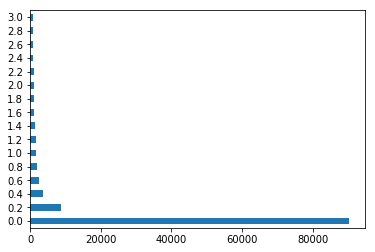

In [11]:
weather_df.Rainfall.value_counts()[:3].plot(kind='barh')

In [12]:
print(weather_df.Evaporation.isnull().sum())
print(len(weather_df.Evaporation))

60843
142193


In [13]:
weather_df.Sunshine.describe()
print(weather_df.Sunshine.isnull().sum())

67816


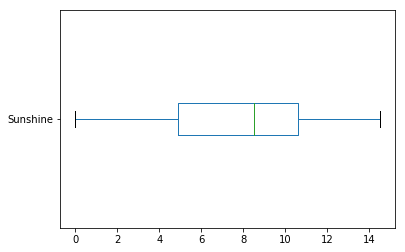

In [14]:
weather_df.Sunshine.plot(kind='box', vert=False)

W      9780
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: WindGustDir, dtype: int64
9330


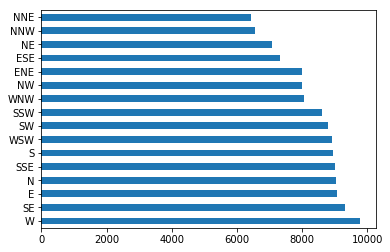

In [15]:
print(weather_df.WindGustDir.value_counts())
print(weather_df.WindGustDir.isnull().sum())
weather_df.WindGustDir.value_counts().plot(kind='barh')

count    132923.000000
mean         39.984292
std          13.588801
min           6.000000
25%          31.000000
50%          39.000000
75%          48.000000
max         135.000000
Name: WindGustSpeed, dtype: float64
9270


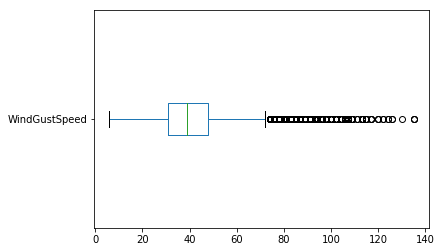

In [16]:
print(weather_df.WindGustSpeed.describe())
print(weather_df.WindGustSpeed.isnull().sum())
weather_df.WindGustSpeed.plot(kind='box', vert=False)

SE     10663
W       9911
S       9598
WSW     9329
SW      9182
SSE     9142
N       8667
WNW     8656
NW      8468
ESE     8382
E       8342
NE      8164
SSW     8010
NNW     7733
ENE     7724
NNE     6444
Name: WindDir3pm, dtype: int64
3778


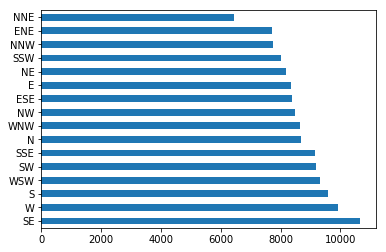

In [17]:
print(weather_df.WindDir3pm.value_counts())
print(weather_df.WindDir3pm.isnull().sum())
weather_df.WindDir3pm.value_counts().plot(kind='barh')